In [1]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import TensorBoardLogger
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from src.forward_operator.operators import cfa_operator
from src.baseline_method.inversion_baseline import Inverse_problem
from src.lightning_classes import U_PDHG_system, DataModule
from src.data_loader import RGBDataset, RGB_SPECTRAL_STENCIL

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CFA = 'bayer'
TRAIN_DIR = 'images/train'
VAL_DIR = 'images/val'
TEST_DIR = 'images/test'
NB_STAGES = 8
BATCH_SIZE = 128
LEARNING_RATE = 1e-2
NB_EPOCHS = 200

OP = cfa_operator(CFA, [80, 120, 3], RGB_SPECTRAL_STENCIL, 'dirac')
baseline_inversion = Inverse_problem(CFA, False, 0, [80, 120, 3], RGB_SPECTRAL_STENCIL, 'dirac')

In [3]:
train_dataset = RGBDataset(TRAIN_DIR, OP.direct, baseline_inversion)
val_dataset = RGBDataset(VAL_DIR, OP.direct, baseline_inversion)
test_dataset = RGBDataset(TEST_DIR, OP.direct, baseline_inversion)

data_module = DataModule(train_dataset, val_dataset, test_dataset, BATCH_SIZE)

model = U_PDHG_system(LEARNING_RATE, NB_STAGES, CFA, RGB_SPECTRAL_STENCIL, 3)

In [4]:
logger = TensorBoardLogger('tb_logs', default_hp_metric=False)

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20)
lr_monitor = LearningRateMonitor()
save_best = ModelCheckpoint(filename='best', monitor='val_loss')
trainer = pl.Trainer(max_epochs=NB_EPOCHS, callbacks=[early_stop, lr_monitor, save_best], logger=logger)

# tuner = Tuner(trainer)
# tuner.lr_find(model, datamodule=data_module)
# print(model.lr)
# tuner.scale_batch_size(model, datamodule=data_module, init_val=16)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | U_PDGH | 1.8 K 
---------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)


/home/mullemat/.pyenv/versions/torch/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 21: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it, v_num=1, val_loss=0.00118]


In [6]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.002826872980222106    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.002826872980222106}]

In [7]:
model = U_PDHG_system.load_from_checkpoint(f'tb_logs/lightning_logs/version_{trainer.logger.version}/checkpoints/best.ckpt')
model.eval()

img = Image.open('images/val_/3096.jpg')
x = np.array(img.resize((img.size[0] // 4, img.size[1] // 4))).astype(np.float32) / 255
y = OP.direct(x)
input_data = torch.tensor(np.concatenate((y[:, :, None], baseline_inversion(y)), axis=2), dtype=torch.float, device=DEVICE)[None]

with torch.no_grad():
    x_hat = model(input_data)[0].cpu().detach().numpy()

28.8378514087667
28.83785138295587


/tmp/ipykernel_102340/2905924800.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(peak_signal_noise_ratio(x, baseline_inversion(y)))


Text(0.5, 1.0, 'Reconstruction')

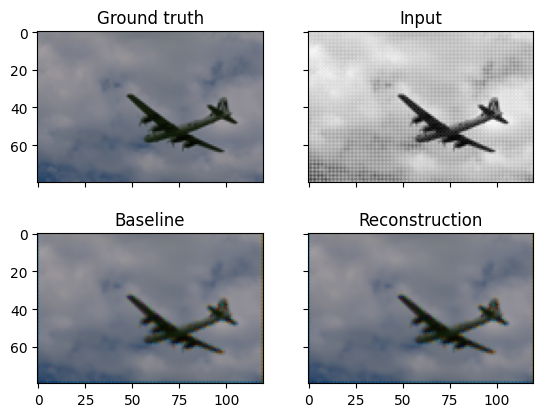

In [8]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

print(peak_signal_noise_ratio(x, baseline_inversion(y)))
print(peak_signal_noise_ratio(x, x_hat))
axs[0, 0].imshow(x)
axs[0, 0].set_title('Ground truth')
axs[0, 1].imshow(y, cmap='gray')
axs[0, 1].set_title('Input')
axs[1, 0].imshow(baseline_inversion(y))
axs[1, 0].set_title('Baseline')
axs[1, 1].imshow(x_hat)
axs[1, 1].set_title('Reconstruction')